# February, 28th 2021

**Motivation**: Overlapping communities.<br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from tqdm.notebook import tqdm

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Louvain
import community as community_louvain


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Simulation

Now with overlapping block structure.

### Overlapping communities

Still using the hierarchichal-modular (HM) model.

In [2]:
# HIDE CODE


block_size = 30
num_blocks = 10
overlap_size = 10

# a_c = get_adjacency(block_size=block_size, num_blocks=num_blocks, mode='RAND')
a_m = get_adjacency(
    block_size=block_size,
    num_blocks=num_blocks,
    overlap_size=overlap_size,
    mode='M',
    random_state=RANDOM_STATE,
)
a_hm = get_adjacency(
    block_size=block_size,
    num_blocks=num_blocks,
    overlap_size=overlap_size,
    mode='HM',
    random_state=RANDOM_STATE,
)

g_m = nx.from_numpy_matrix(a_m)
g_hm = nx.from_numpy_matrix(a_hm)

# get configuration model
sequence = sorted([d for n, d in g_hm.degree()], reverse=True)
g_c = nx.configuration_model(sequence)
g_c = nx.Graph(g_c)
g_c.remove_edges_from(nx.selfloop_edges(g_c))
a_c = nx.adjacency_matrix(g_c).toarray()

# put in dicts
graphs = {'C': g_c, 'M': g_m, 'HM': g_hm}
adjacencies = {'C': a_c, 'M': a_m, 'HM': a_hm}
eigs = {k: np.linalg.eig(a) for k, a in adjacencies.items()}
poses = {k: nx.spring_layout(g, iterations=1000) for k, g in graphs.items()}
cmaps = {'C': 'Purples', 'M': 'Reds', 'HM': 'Blues'}
palette = sns.color_palette('tab10', n_colors=10, as_cmap=False)
colors = np.array(palette)[[4, 3, 0]]
colors = {k: colors[i] for i, k in enumerate(cmaps.keys())}

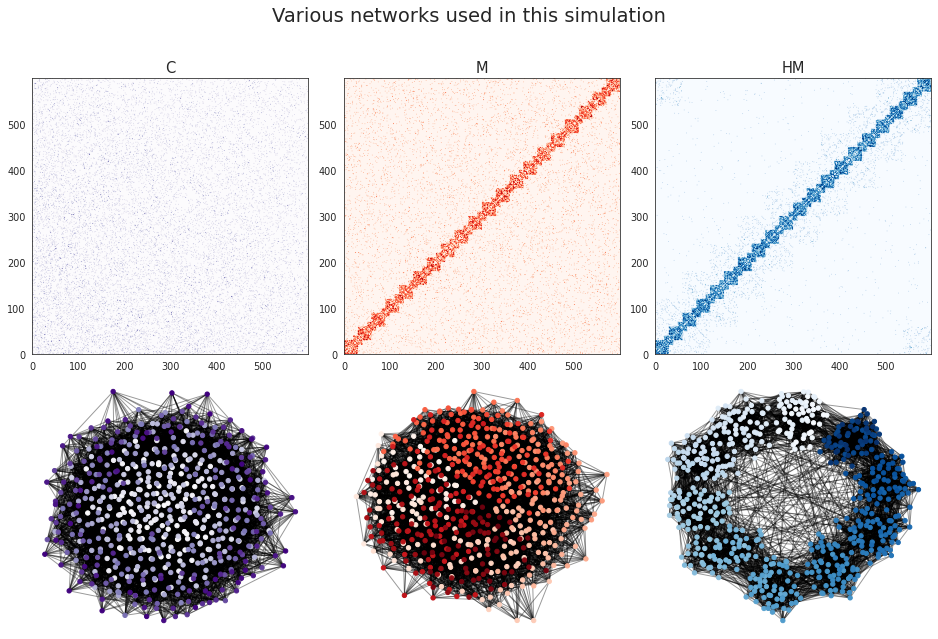

In [24]:
# HIDE CODE


figsize = (13.5, 9)
dpi = 70

sns.set_style('white')
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(nrows=2, ncols=3, height_ratios=[1.3, 1], hspace=0)

for idx, (k, g) in enumerate(graphs.items()):
    ax0 = fig.add_subplot(gs[0, idx])
    ax1 = fig.add_subplot(gs[1, idx])
    
    im = ax0.imshow(adjacencies[k], cmap=cmaps[k], interpolation='antialiased')
    ax0.invert_yaxis()
    ax0.set_title(k, fontsize=15)

    nx.draw_networkx_nodes(g, poses[k], node_color=range(g.order()), node_size=20, cmap=cmaps[k], ax=ax1)
    nx.draw_networkx_edges(g, poses[k], alpha=0.4, ax=ax1)
    ax1.axis('off')

fig.suptitle('Various networks used in this simulation', fontsize=20, y=1.01)
fig.tight_layout(h_pad=0)
plt.show()

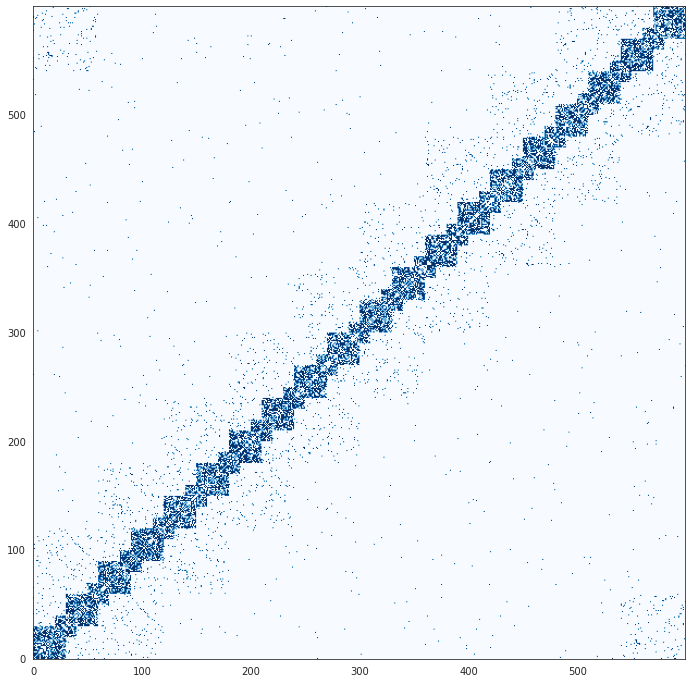

In [25]:
plt.figure(figsize=(15, 12))
plt.imshow(adjacencies['HM'], cmap=cmaps['HM'])
plt.gca().invert_yaxis()

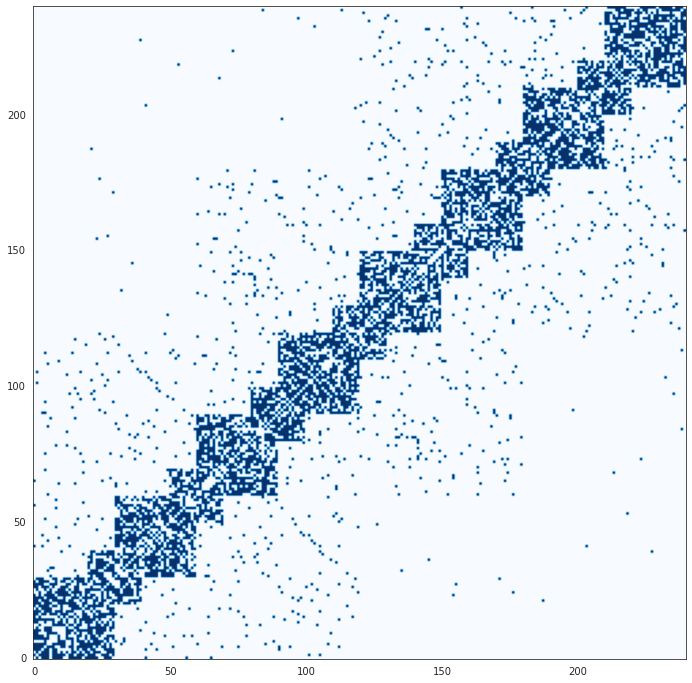

In [26]:
plt.figure(figsize=(15, 12))
plt.imshow(adjacencies['HM'][:240, :240], cmap=cmaps['HM'], interpolation="antialiased")#, interpolation='None')
plt.gca().invert_yaxis()

## Network measures

In this section I will study in what ways these networks are different or similar using well known network measures.

### Degree distribution

I chose the parameters in generating the simulation in a way that all these networks have roughly the same digree distribution.

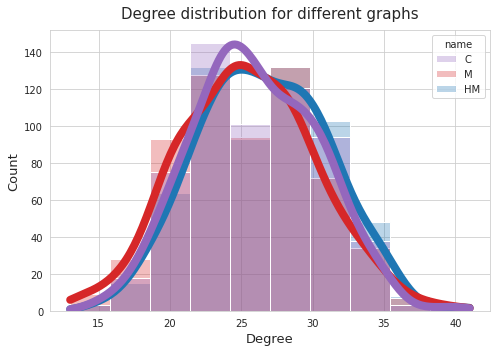

In [27]:
# HIDE CODE


deg_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    data_dict = {
        'name': [k] * len(nodes),
        'node': nodes,
        'deg': degrees,
    }
    deg_df = pd.concat([deg_df, pd.DataFrame.from_dict(data_dict)])
    
sns.set_style('whitegrid')
plt.figure(figsize=(7, 5))
sns.histplot(
    data=deg_df, x='deg', hue='name', palette=colors, kde=True, bins=10,
    element='bars', fill=True, alpha=0.3, line_kws={'lw': 8})
plt.title('Degree distribution for different graphs', fontsize=15, y=1.02)
plt.xlabel('Degree', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.tight_layout()
plt.show()

In [28]:
# HIDE CODE


measures_df = pd.DataFrame()

for k, g in graphs.items():
    nodes, degrees = list(zip(*g.degree()))
    
    data_dict = {
        'name': [k] * 8,
        'lbl': [
            'transitivity',
            'avg_clustering',
            'large_clique_size',
            'degree_corr_coef',
            'avg_shortest_path_len',
            'local_efficiency',
            'global_efficiency',
            'sigma',
            # 'omega',
        ],
        'val': [
            transitivity(g),
            average_clustering(g),
            large_clique_size(g),
            degree_pearson_correlation_coefficient(g),
            average_shortest_path_length(g),
            local_efficiency(g),
            global_efficiency(g),
            sigma(g, niter=1, nrand=1, seed=42),
            # omega(g, niter=1, nrand=1, seed=42),
        ],
    }
    measures_df = pd.concat([measures_df, pd.DataFrame.from_dict(data_dict)])

### Other measures

Here I will discuss 8 commonly used network measures and then report their values on different networks in the simulation.

#### i) Clustering related measures
- **transitivity**:
- **avg_clustering**: 
- **large_clique_size**:
- **assortativity**:

#### ii) Path length related measures
- **avg_shortest_path_len**:
- **local_efficiency**:
- **global_efficiency**:

#### iii) Small-world-ness
- **sigma**: introduced in... 


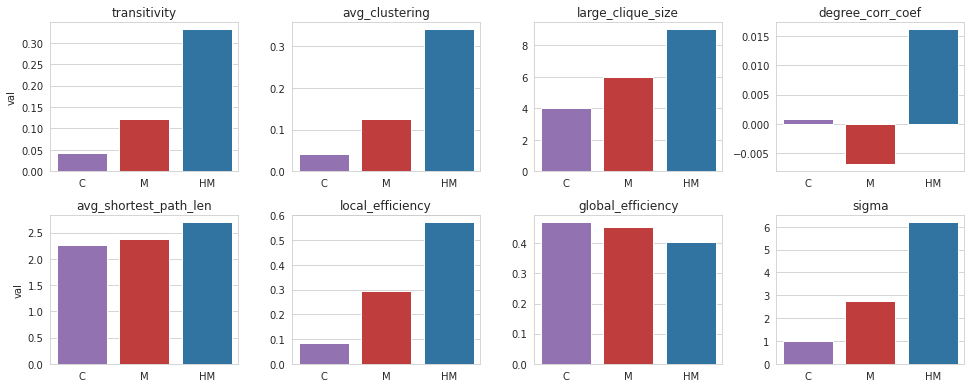

In [29]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 5.5))

for idx, lbl in enumerate(measures_df.lbl.unique()):
    i, j = idx//ncols, idx%ncols
    sns.barplot(
        data=measures_df.loc[measures_df.lbl == lbl],
        y='val', x='name', palette=colors, ax=axes[i, j],
    )
    axes[i, j].set_title(lbl, fontsize=12)
    axes[i, j].set_xlabel('')
    if j > 0:
        axes[i, j].set_ylabel('')
    
fig.tight_layout()
plt.show()

interpretation of results:

## Centrality measures

Now we bring our focus from the network as a whole to individual nodes.  Some of these nodes are more *central* than others.  What do I mean by central?  Here is measures I will report on:

- **Degree centrality**:
- **Closeness centrality**:
- **Harmonic centrality**:
- **Betweenness centrality**:
- **Information centrality**:
- **Eigenvector centrality**:
- **Katz centrality**:

Now let's visualize the network based on these centrality measures.

In [30]:
# HIDE CODE


centralities = {}

for k, g in graphs.items():
    centralities[k] = {
        'degree': nx.degree_centrality(g),
        'closeness': nx.closeness_centrality(g),
        'harmonic': nx.harmonic_centrality(g),
        'betweenness': nx.betweenness_centrality(g),
        'information': nx.information_centrality(g),
        'eigenvector': nx.eigenvector_centrality(g),
        'katz': nx.katz_centrality_numpy(g),
    }

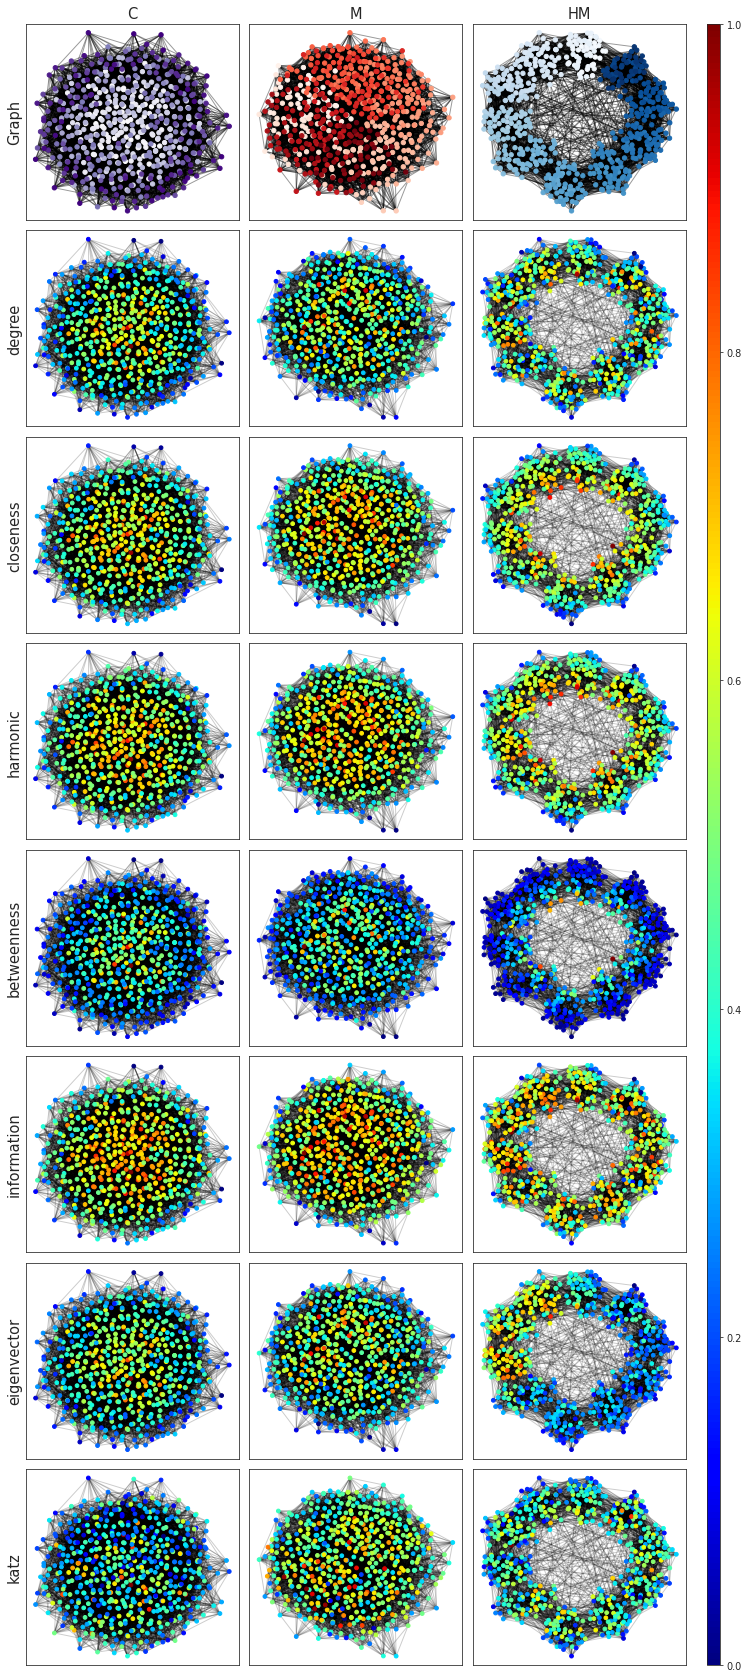

In [32]:
# HIDE CODE


figsize = (10, 24)
dpi = 70

sns.set_style('white')
nrows, ncols= len(centralities['C']) + 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)

for i, (k, g) in enumerate(graphs.items()):

    nx.draw_networkx_nodes(g, poses[k], node_color=range(g.order()), node_size=20, cmap=cmaps[k], ax=axes[0, i])
    nx.draw_networkx_edges(g, poses[k], alpha=0.4, ax=axes[0, i])
    axes[0, i].set_title(k, fontsize=15)
    if i == 0:
        axes[0, i].set_ylabel('Graph', fontsize=15)
    # axes[0, i].axis('off')
    
    for j, (lbl, vals) in enumerate(centralities[k].items()):
        a = min(vals.values())
        b = max(vals.values())
        normalized_vals = [(x-a) / (b-a) for x in vals.values()]
        
        nx.draw_networkx_nodes(g, poses[k], node_color=normalized_vals,
                               node_size=15, cmap='jet', ax=axes[j+1, i])
        nx.draw_networkx_edges(g, poses[k], alpha=0.2, ax=axes[j+1, i])
        if i == 0:
            axes[j+1, i].set_ylabel(lbl, fontsize=15)
        # axes[j+1, i].axis('off')

fig.tight_layout()

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.1 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=cax, orientation="vertical")
plt.show()

interpret the graph

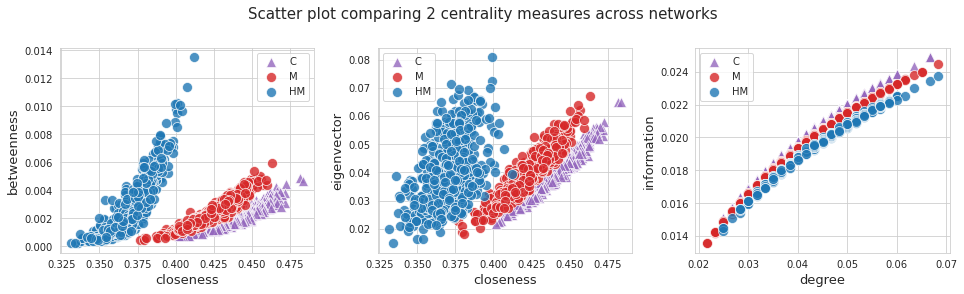

In [33]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4))

pairs = [('closeness', 'betweenness'), ('closeness', 'eigenvector'), ('degree', 'information')]
for idx, (x, y) in enumerate(pairs):
    for k, color in colors.items():
        marker = '^' if k in ['C', 'ER'] else 'o'
        sns.scatterplot(
            x=list(centralities[k][x].values()),
            y=list(centralities[k][y].values()),
            color=color, s=100, label=k, marker=marker, alpha=0.8, ax=axes[idx],
        )
    axes[idx].set_xlabel(x, fontsize=13)
    axes[idx].set_ylabel(y, fontsize=13)

fig.suptitle('Scatter plot comparing 2 centrality measures across networks', fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

interpret the graph

## Community structure

Time for fun stuff.  In this section I will study behavior of different community detection algorithms on simulated networks.  First, let's start with a classic, but not so great algorithm.  In this section we will use another network measure known as modularity:

- **Modularity**: $Q = \frac{1}{N}\sum_i$

### Louvain algorithm

Wants to directly maximize Q, modularity

In [36]:
# HIDE CODE


# run algorithm
communities_louvain = {}
max_k = 1000
for k, g in tqdm(graphs.items(), leave=False):
    tmp = {}
    for resolution in tqdm(np.logspace(-2, 1, max_k+1), leave=False):
        partition = community_louvain.best_partition(g, resolution=resolution, random_state=RANDOM_STATE)
        
        comm = collections.defaultdict(list)
        for node, v in sorted(partition.items()):
            comm[v].append(node)  
        tmp[resolution] = dict(comm)
        
    communities_louvain[k] = tmp


# process results
modularities_louvain = {}
num_communities_louvain = {}

for k, g in graphs.items():
    modul = {}
    num_comm = {}
    for resolution, partition in communities_louvain[k].items():
        community_list = list(partition.values())
        modul[resolution] = nx_comm.modularity(g, communities=community_list)
        num_comm[resolution] = len(community_list)
    
    modularities_louvain[k] = modul
    num_communities_louvain[k] = num_comm

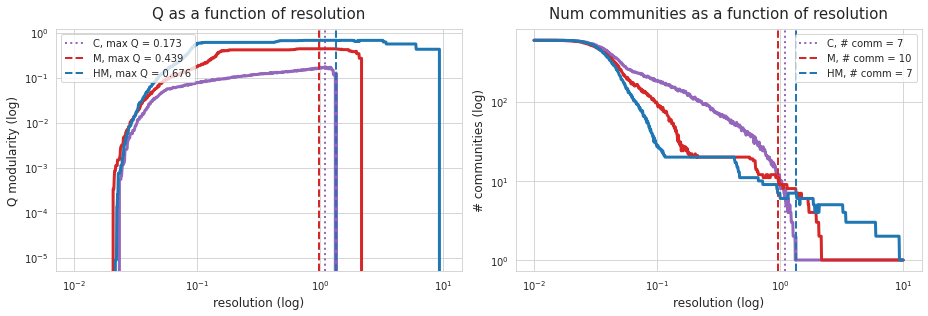

In [38]:
# HIDE CODE


fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')

for k, color in colors.items():
    x0, y0 = tuple(zip(*modularities_louvain[k].items()))
    axes[0].loglog(x0, y0, lw=3, color=color)
    ls = '--' if k in ['M', 'HM'] else ':'
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    res_at_max_mod = x0[max_mod_idx]
    lbl = '{}, max Q = {:.3f}'.format(k, max_mod)
    axes[0].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)
    
    x1, y1 = tuple(zip(*num_communities_louvain[k].items()))
    axes[1].loglog(x1, y1, lw=3, color=color)
    lbl = '{}, # comm = {:d}'.format(k, y1[max_mod_idx])
    axes[1].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[0].set_xlabel('resolution (log)', fontsize=12)
axes[0].set_ylabel('Q modularity (log)', fontsize=12)
axes[0].legend(loc='upper left')

axes[1].set_title('Num communities as a function of resolution', fontsize=15, y=1.02)
axes[1].set_xlabel('resolution (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='upper right')

fig.tight_layout()
plt.show()

interpret this graph

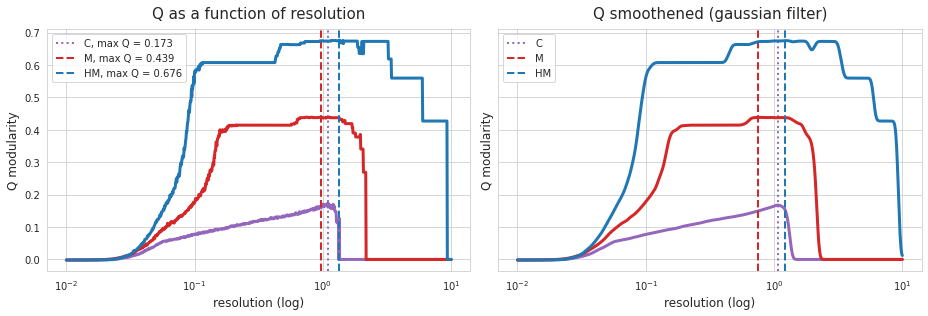

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all', sharey='all')

for j in range(2):
    for k, color in colors.items():
        x0, y0 = tuple(zip(*modularities_louvain[k].items()))
        if j == 1:
            y0 = gaussian_filter(y0, sigma=5)
        axes[j].plot(x0, y0, lw=3, color=color)
        ls = '--' if k in ['M', 'HM'] else ':'
        max_mod_idx = np.argmax(y0)
        max_mod = y0[max_mod_idx]
        res_at_max_mod = x0[max_mod_idx]
        lbl = '{}, max Q = {:.3f}'.format(k, max_mod) if j == 0 else '{}'.format(k)
        axes[j].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)
        axes[j].set_xscale('log')
        axes[j].legend(loc='upper left')
        axes[j].set_xlabel('resolution (log)', fontsize=12)
        axes[j].set_ylabel('Q modularity', fontsize=12)

axes[0].set_title('Q as a function of resolution', fontsize=15, y=1.02)
axes[1].set_title('Q smoothened (gaussian filter)', fontsize=15, y=1.02)

fig.tight_layout()
plt.show()

interpret this graph, and talk about Q could be misleading

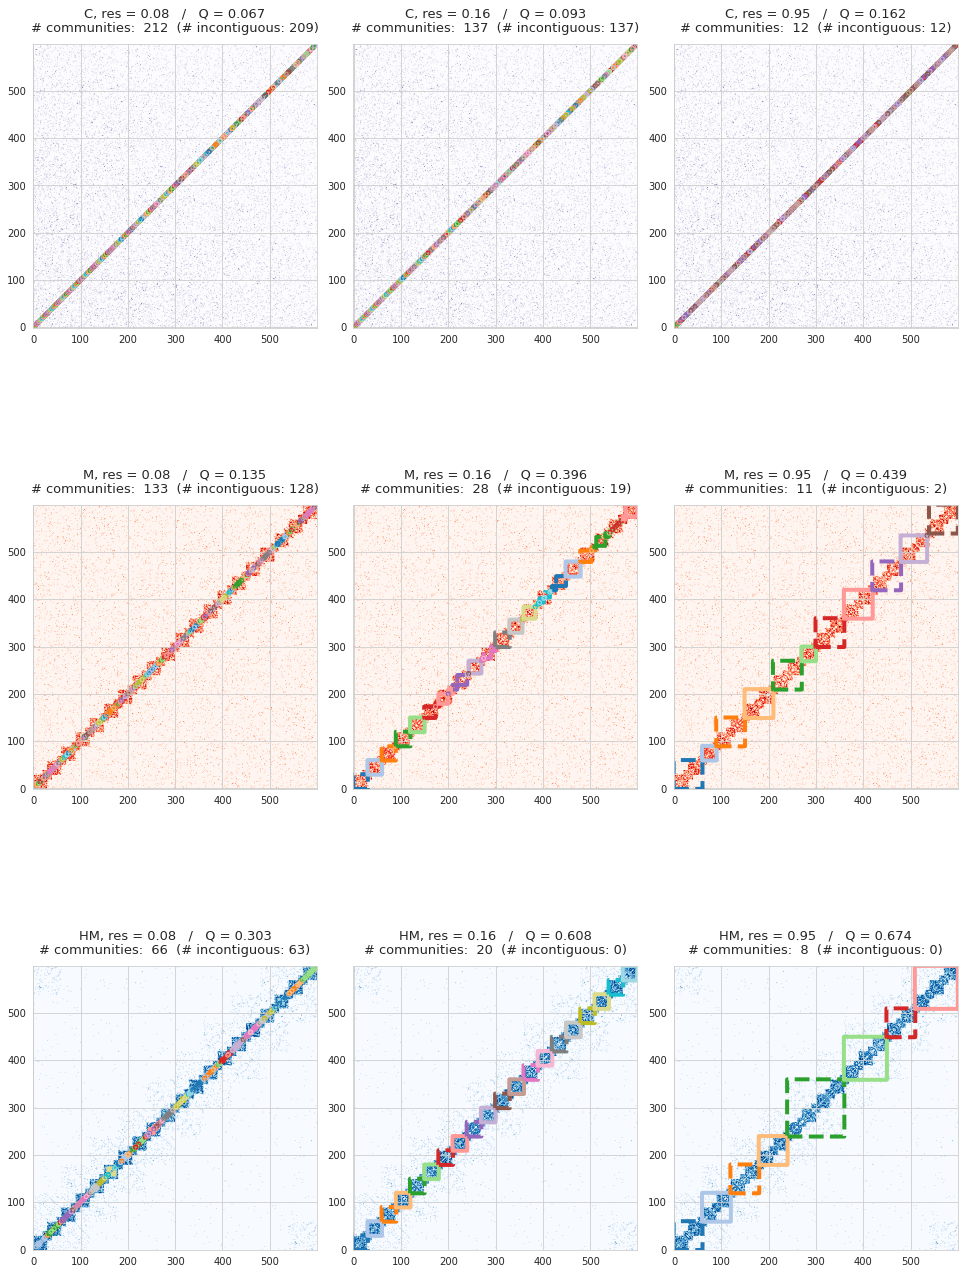

In [40]:
# HIDE CODE


sns.set_style('whitegrid')
idxs_to_display = [300, 400, 659]
fig, axes = plt.subplots(len(graphs), len(idxs_to_display), figsize=(13.5, 20))

for j, name in enumerate(graphs.keys()):
    for i, idx in enumerate(idxs_to_display):
        axes[j, i].imshow(adjacencies[name], cmap=cmaps[name])
        axes[j, i].invert_yaxis()

        community_dict = list(communities_louvain[name].values())[idx]
        community_list = list(community_dict.values())
        palette = sns.color_palette('tab20', n_colors=len(community_list))
        num_incontiguous = 0
        for ll, (comm_list, color) in enumerate(zip(community_list, palette)):
            contiguous_list = []
            for k, g in itertools.groupby(enumerate(comm_list), lambda ix: ix[0]-ix[1]):
                contiguous_list.append(list(map(itemgetter(1), g)))

            if len(contiguous_list) > 1:
                num_incontiguous += 1

            for item in contiguous_list:
                rect = patches.FancyBboxPatch(
                    (item[0],) * 2,
                    item[-1] - item[0],
                    item[-1] - item[0],
                    linewidth=4,
                    edgecolor=color,
                    facecolor='none',
                    boxstyle="round,pad=1",
                    ls='--' if ll%2==0 else '-',
                )
                axes[j, i].add_patch(rect)

        msg = "{:s}, res = {:.2f}   /   Q = {:.3f}\n# communities:  {:d}  (# incontiguous: {:d})"
        msg = msg.format(
            name, list(modularities_louvain[name].keys())[idx],
            list(modularities_louvain[name].values())[idx],
            len(community_list), num_incontiguous,
        )
        axes[j, i].set_title(msg, fontsize=13, y=1.02)

fig.tight_layout()
plt.show()

just like before, interpret this too

## Spectral decomposition

It is interesting to look at eigenspectrum of adjacency matrix.  It can be insightful about linearized dynamics and so on.

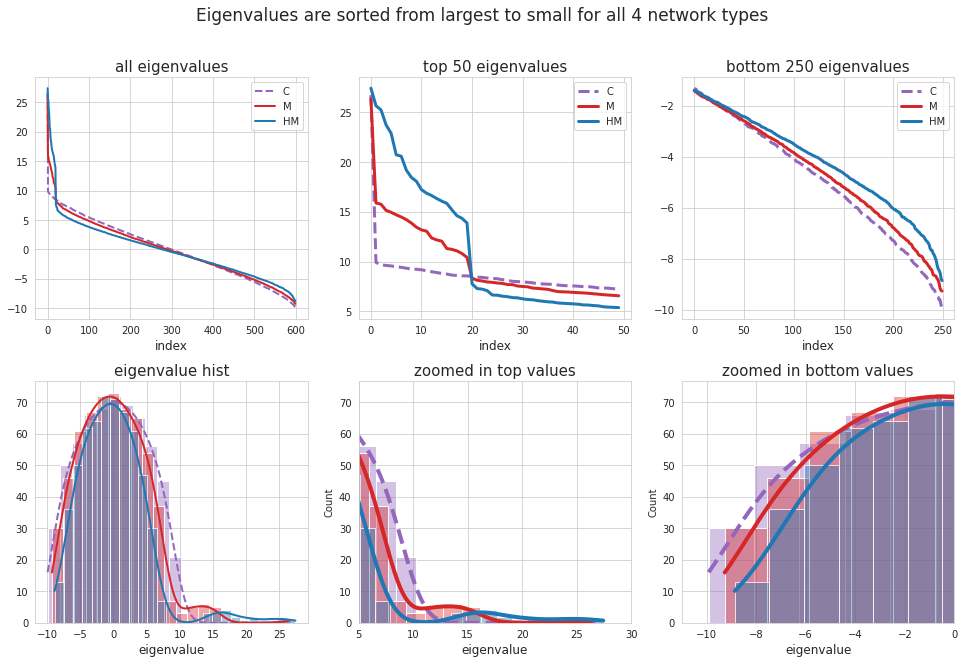

In [43]:
# HIDE CODE


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13.5, 9))

num_top_eig = 50
num_bot_eig = 250
for k, color in colors.items():
    ls = '--' if k in ['C', 'ER'] else '-'
    axes[0, 0].plot(sorted(eigs[k][0], reverse=True), lw=2, color=color, ls=ls, label=k)
    axes[0, 1].plot(sorted(eigs[k][0], reverse=True)[:num_top_eig], lw=3, color=color, ls=ls, label=k)
    axes[0, 2].plot(sorted(eigs[k][0], reverse=True)[-num_bot_eig:], lw=3, color=color, ls=ls, label=k)
    
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 0],
                 kde=True, line_kws={'lw': 2, 'ls': ls})
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 1],
                 kde=True, line_kws={'lw': 4, 'ls': ls})
    sns.histplot(eigs[k][0], color=color, label=k, alpha=0.4, ax=axes[1, 2],
                 kde=True, line_kws={'lw': 4, 'ls': ls})
    
axes[0, 0].set_title('all eigenvalues', fontsize=15)
axes[0, 1].set_title('top {:d} eigenvalues'.format(num_top_eig), fontsize=15)
axes[0, 2].set_title('bottom {:d} eigenvalues'.format(num_bot_eig), fontsize=15)
axes[1, 0].set_title('eigenvalue hist', fontsize=15)
axes[1, 1].set_title('zoomed in top values'.format(num_top_eig), fontsize=15)
axes[1, 2].set_title('zoomed in bottom values'.format(num_bot_eig), fontsize=15)

axes[1, 1].set_xlim(5, 30)
axes[1, 2].set_xlim(-11, 0)
for j in range(3):
    axes[0, j].set_xlabel('index', fontsize=12)
    axes[1, j].set_xlabel('eigenvalue', fontsize=12)
    if j == 0:
        axes[0, 0].set_ylabel('eigenvalue', fontsize=12)
        axes[1, 0].set_ylabel('count', fontsize=12)
    else:
        axes[0, 0].set_ylabel('')
        axes[1, 0].set_ylabel('')
    axes[0, j].legend()

fig.suptitle('Eigenvalues are sorted from largest to small for all 4 network types', fontsize=17, y=1.02)
fig.tight_layout()
    
plt.show()

### Localization analysis

Add the anderson stuff here.

#### Inverse participation ratio (IPR)

Blah blah

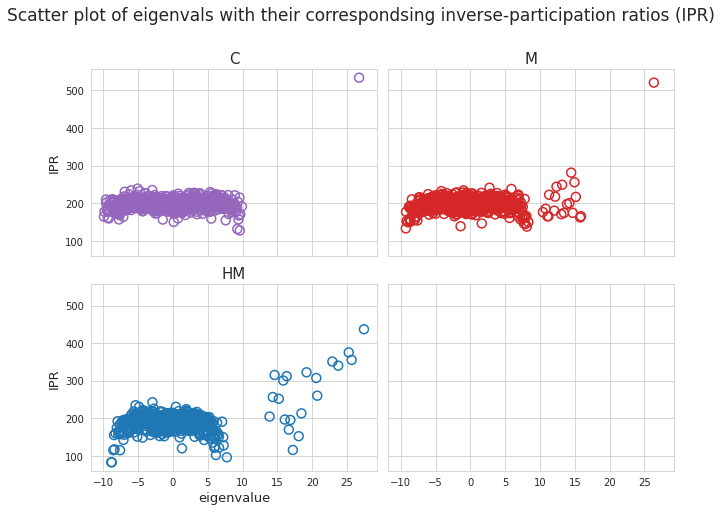

In [44]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(9, 7), sharex='all', sharey='all')


for idx, (k, (w, v)) in enumerate(eigs.items()):
    i, j = idx//ncols, idx%ncols
    ipr = 1 / np.power(v, 4).sum(0)
    axes[i, j].scatter(w, ipr, color='none', edgecolors=colors[k], s=80, lw=1.5)
    axes[i, j].set_title(k, fontsize=15)
    if i == 1:
        axes[i, j].set_xlabel('eigenvalue', fontsize=13)
    if j == 0:
        axes[i, j].set_ylabel('IPR', fontsize=13)

fig.suptitle('Scatter plot of eigenvals with their correspondsing inverse-participation ratios (IPR)',
             fontsize=17, y=1.01)
fig.tight_layout()
plt.show()

interpret graph

1

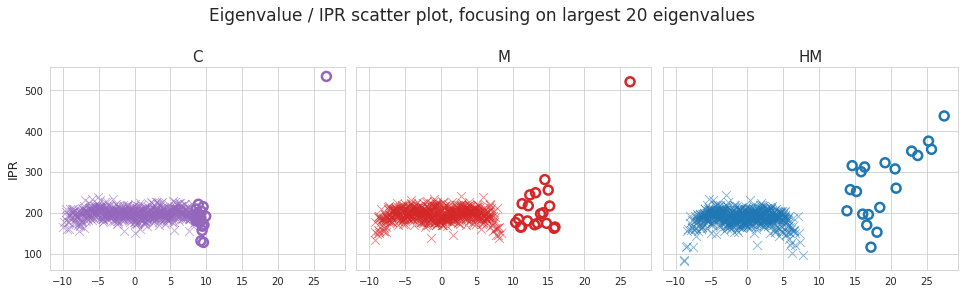

In [50]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4), sharex='all', sharey='all')
if len(axes.shape) < 2:
    axes = axes.reshape(nrows, ncols)

for idx, (k, (w, v)) in enumerate(eigs.items()):
    i, j = idx//ncols, idx%ncols
    ipr = 1 / np.power(v, 4).sum(0)
    sorted_indxs = np.argsort(w)
    axes[i, j].scatter(w[sorted_indxs[:-20]], ipr[sorted_indxs[:-20]],
                       color=colors[k], marker='x', s=80, lw=1., alpha=0.5)
    axes[i, j].scatter(w[sorted_indxs[-20:]], ipr[sorted_indxs[-20:]],
                       color='none', edgecolors=colors[k], s=80, lw=2.5)
    axes[i, j].set_title(k, fontsize=15)
    if i == 1:
        axes[i, j].set_xlabel('eigenvalue', fontsize=13)
    if j == 0:
        axes[i, j].set_ylabel('IPR', fontsize=13)

fig.suptitle('Eigenvalue / IPR scatter plot, focusing on largest 20 eigenvalues',
             fontsize=17, y=1.01)
fig.tight_layout()
plt.show()

interpret graph

#### Plotting eigenvectors

Here I will plot some of the eigenvectors for different networks to see how they are different.

##### top eigenvectors ordered by eigenvalue size

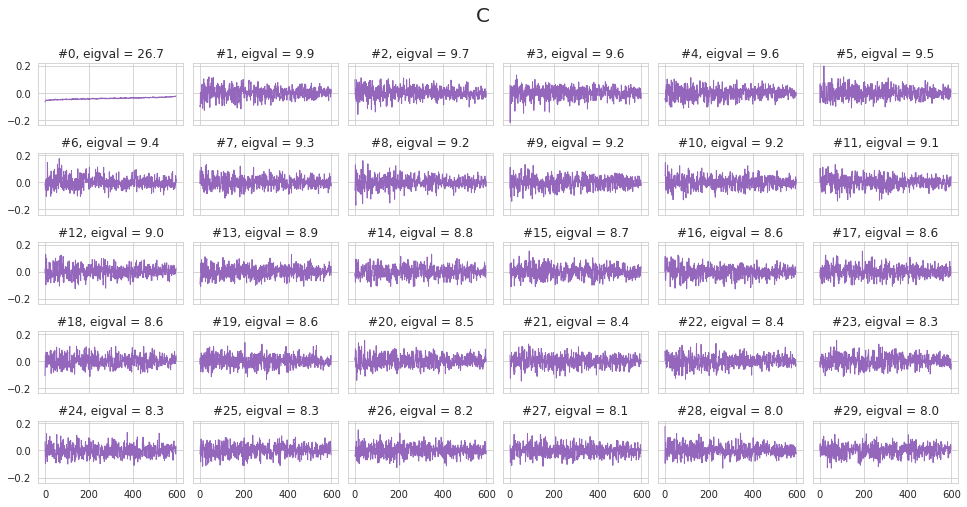

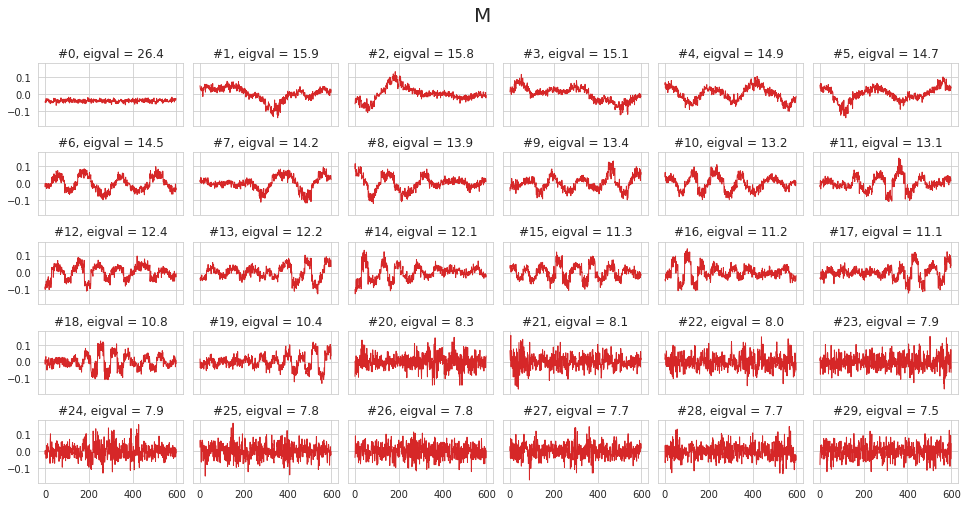

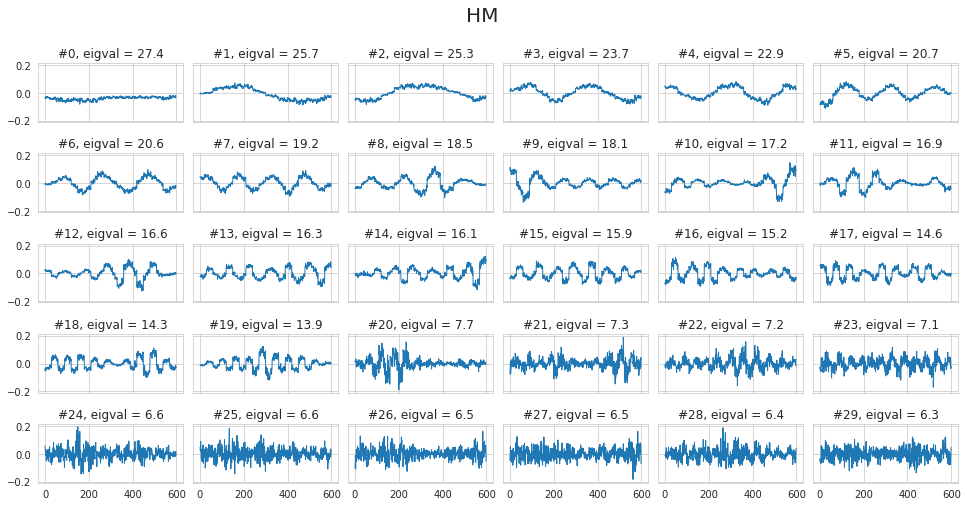

In [51]:
# HIDE CODE


sns.set_style('whitegrid')
nrows, ncols = 5, 6

for k, (w, v) in eigs.items():
    sort_idxs = np.argsort(w)[::-1]

    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7), sharex='all', sharey='all')
    for idx in range(nrows*ncols):
        i, j = idx//ncols, idx%ncols 
            # sort_abs_idxs = np.argsort(np.abs(w))
        axes[i, j].plot(v[:, sort_idxs[idx]], color=colors[k], label=k, lw=1)
        axes[i, j].set_title('#{:d}, eigval = {:.1f}'.format(idx, w[sort_idxs[idx]]))

    fig.suptitle(k, fontsize=20, y=1.)
    fig.tight_layout()
    plt.show()

### Overlapping communities

In [111]:
import demon

In [128]:
# run algorithm
communities_demon = {}

for k, g in tqdm(graphs.items(), leave=False):
    tmp = {}
    for epsilon in tqdm(np.linspace(0, 1, max_k+1), leave=False):
        dm = demon.Demon(g, epsilon=epsilon, min_community_size=3)
        coms = dm.execute()
        tmp[epsilon] = coms

    communities_demon[k] = tmp


# process results
modularities_demon = {}
num_communities_demon = {}

for k, g in graphs.items():
    modul = {}
    num_comm = {}
    for epsilon, community_list in communities_demon[k].items():
        try:
            modul[epsilon] = nx_comm.modularity(g, communities=community_list)
        except:
            modul[epsilon] = 0.
        num_comm[epsilon] = len(community_list)
    
    modularities_demon[k] = modul
    num_communities_demon[k] = num_comm

Exec: 100%|████████████████████████

Time:  'execute' 0.62 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.64 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.58 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.58 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.59 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.63 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.59 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.60 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.60 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.60 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.60 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.64 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.63 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.65 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.56 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.56 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.67 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.65 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.62 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.62 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.68 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.69 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.57 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.62 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.61 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.59 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.75 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.73 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.77 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.77 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.74 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.71 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.89 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.72 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.84 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.82 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.86 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.82 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.84 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.82 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.95 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.93 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.02 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.95 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.99 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.09 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.02 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.98 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.07 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.05 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.99 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.11 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.15 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.09 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.14 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.18 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.34 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.29 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.26 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.27 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.30 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.51 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.43 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.45 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.57 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.55 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.58 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.51 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.60 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.37 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.37 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.39 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.41 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.39 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.47 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.40 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.44 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.42 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.66 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.57 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.69 sec
------------------------------------


Exec: 100%|████████████████████████

Time:  'execute' 0.70 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.69 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.75 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.71 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.77 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.72 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.75 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.75 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.70 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.72 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.77 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.70 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.72 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.86 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.81 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.78 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.81 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.76 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.80 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.74 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.75 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.81 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.79 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.83 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.85 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.84 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.87 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.87 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.94 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.91 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.90 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.92 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 0.85 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.03 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.00 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.05 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.04 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.11 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.06 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.11 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.23 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.14 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.18 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.18 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.23 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.26 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.25 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.19 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.27 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.41 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.28 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.21 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.27 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.24 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.34 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.35 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.26 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.32 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.29 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.46 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.41 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.30 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.39 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.25 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.31 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.32 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.29 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.31 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.26 sec
------------------------------------


Exec: 100%|████████████████████████

Time:  'execute' 1.20 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.20 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.23 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.21 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.20 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.07 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.15 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.18 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.11 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.11 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.08 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.20 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.14 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.07 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.08 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.07 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.08 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.06 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.07 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.15 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.19 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.09 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.26 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.23 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.14 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.08 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.09 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.22 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.22 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.15 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.19 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.16 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.20 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.13 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.09 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.18 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.23 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.10 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.17 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.15 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.19 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.20 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.23 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.12 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.15 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.22 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.14 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.27 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.21 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.25 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.34 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.34 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.36 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.39 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.46 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.40 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.45 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.52 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.54 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.51 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.54 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.46 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.44 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.49 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.54 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.51 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.40 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.43 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.50 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.56 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.40 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.53 sec
------------------------------------



Exec: 100%|████████████████████████

Time:  'execute' 1.47 sec
------------------------------------


In [160]:
# process results
modularities_demon = {}
num_communities_demon = {}

for k, g in graphs.items():
    modul = {}
    num_comm = {}
    for epsilon, partition in communities_demon[k].items():
        community_list = [list(item) for item in partition]
        try:
            modul[epsilon] = nx_comm.modularity(g, communities=community_list)
        except:
            modul[epsilon] = 0.
        num_comm[epsilon] = len(community_list)
    
    modularities_demon[k] = modul
    num_communities_demon[k] = num_comm

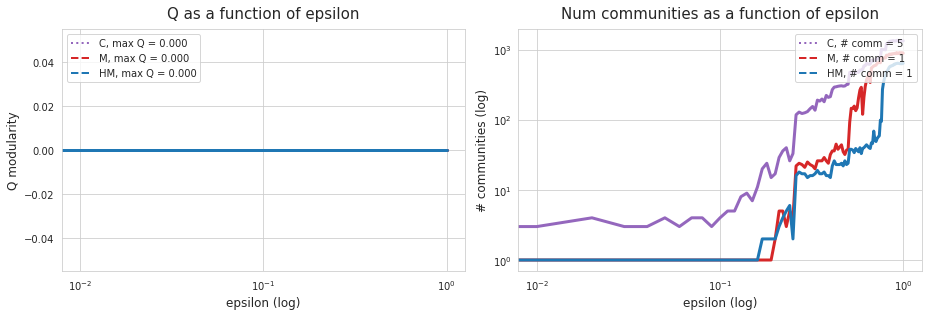

In [162]:
# HIDE CODE


fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), sharex='all')

for k, color in colors.items():
    x0, y0 = tuple(zip(*modularities_demon[k].items()))
    axes[0].plot(x0, y0, lw=3, color=color)
    ls = '--' if k in ['M', 'HM'] else ':'
    max_mod_idx = np.argmax(y0)
    max_mod = y0[max_mod_idx]
    res_at_max_mod = x0[max_mod_idx]
    lbl = '{}, max Q = {:.3f}'.format(k, max_mod)
    axes[0].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)
    
    x1, y1 = tuple(zip(*num_communities_demon[k].items()))
    axes[1].loglog(x1, y1, lw=3, color=color)
    lbl = '{}, # comm = {:d}'.format(k, y1[max_mod_idx])
    axes[1].axvline(res_at_max_mod, color=color, lw=2, ls=ls, label=lbl)

axes[0].set_title('Q as a function of epsilon', fontsize=15, y=1.02)
axes[0].set_xlabel('epsilon (log)', fontsize=12)
axes[0].set_ylabel('Q modularity', fontsize=12)
axes[0].legend(loc='upper left')

axes[1].set_title('Num communities as a function of epsilon', fontsize=15, y=1.02)
axes[1].set_xlabel('epsilon (log)', fontsize=12)
axes[1].set_ylabel('# communities (log)', fontsize=12)
axes[1].legend(loc='upper right')

fig.tight_layout()
plt.show()

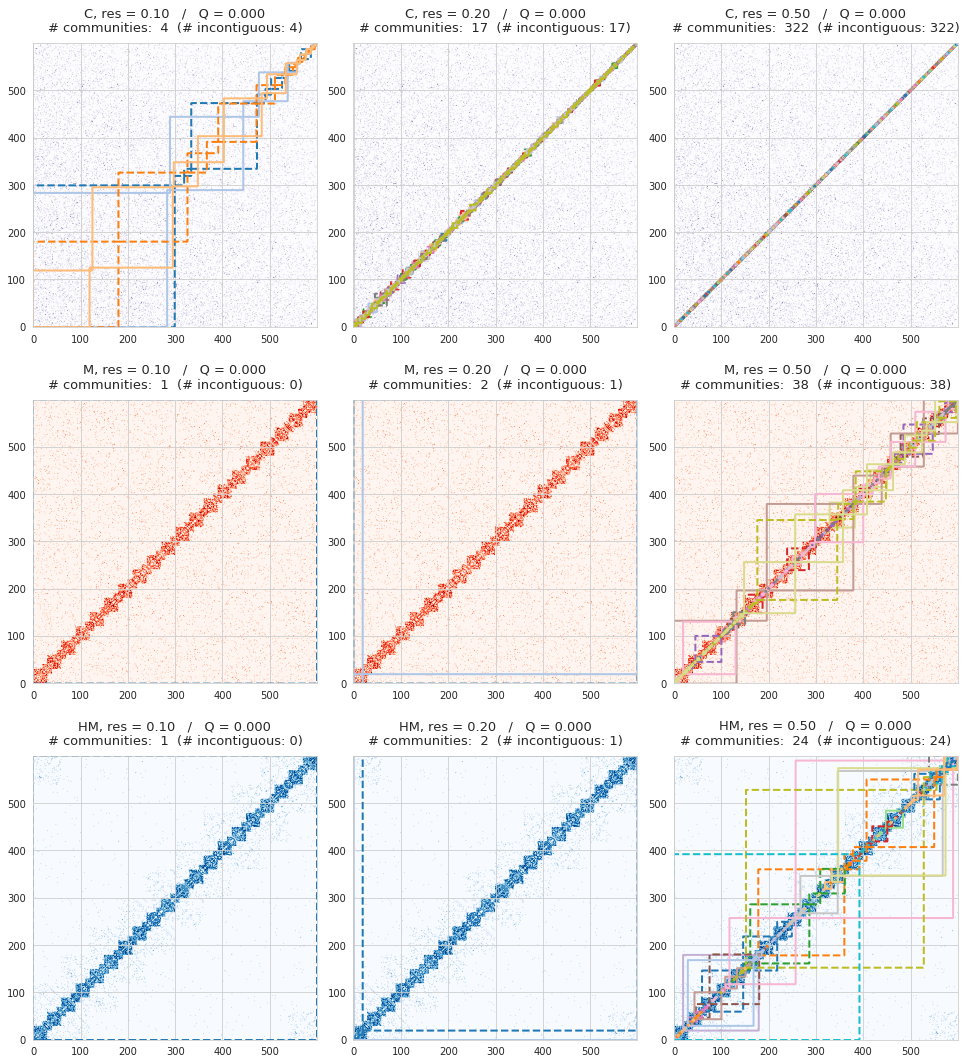

In [163]:
# HIDE CODE


sns.set_style('whitegrid')
idxs_to_display = [10, 20, 50]
fig, axes = plt.subplots(len(graphs), len(idxs_to_display), figsize=(13.5, 15))

for j, name in enumerate(graphs.keys()):
    for i, idx in enumerate(idxs_to_display):
        axes[j, i].imshow(adjacencies[name], cmap=cmaps[name])
        axes[j, i].invert_yaxis()

        community_list = list(communities_demon[name].values())[idx]
        palette = sns.color_palette('tab20', n_colors=len(community_list))
        num_incontiguous = 0
        for ll, (comm_list, color) in enumerate(zip(community_list, palette)):
            contiguous_list = []
            for k, g in itertools.groupby(enumerate(comm_list), lambda ix: ix[0]-ix[1]):
                contiguous_list.append(list(map(itemgetter(1), g)))

            if len(contiguous_list) > 1:
                num_incontiguous += 1

            for item in contiguous_list:
                rect = patches.FancyBboxPatch(
                    (item[0],) * 2,
                    item[-1] - item[0],
                    item[-1] - item[0],
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none',
                    boxstyle="round,pad=1",
                    ls='--' if ll%2==0 else '-',
                )
                axes[j, i].add_patch(rect)

        msg = "{:s}, res = {:.2f}   /   Q = {:.3f}\n# communities:  {:d}  (# incontiguous: {:d})"
        msg = msg.format(
            name, list(modularities_demon[name].keys())[idx],
            list(modularities_demon[name].values())[idx],
            len(community_list), num_incontiguous,
        )
        axes[j, i].set_title(msg, fontsize=13, y=1.02)

fig.tight_layout()
plt.show()

## Discussion

TODO